Machine Learning - Fábio Gomes

# Machine Learning - Projeto para Curso do TCU (10/2020) - por Fábio Gomes

Desafio do negócio - Anualmente são apresentadas na Câmara dos Deputados milhares de proposições legislativas. A adoção de classificação temática realizada de modo automático facilitaria atividades de monitoramento da tramitação de projetos de lei (PL) e outros tipos, como propostas de fiscalização e controle (PFC), segundo grupos temáticos de saúde, ampliando a transparência para a sociedade e agilizando atividades de elaboração legislativa e de fiscalização. Grupo de pesquisa da Câmara dos Deputados sobre Legislativo e Saúde, de que participo, desenvolveu tipologia hierarquizada para classificação de proposições legislativas relacionadas à saúde, contendo quatro grupos temáticos (também possui subcategorias) e pretende-se utilizar essa base para produzir modelo capaz de classificar novas proposições automaticamente.

Solução construída - Desenvolvo esse projeto de ML há mais de um ano (classificação supervisionada de textos de projetos de lei – PL - relacionados à saúde). Houve muitos problemas na conversão de pdf em texto, pois a Câmara usou vários tipos de pdf ao longo do tempo. Em agosto de 2019, foram elaborados alguns modelos por meio do R (base com 7575 PL). O Random Forest foi o modelo mais promissor. Essa experiência permitiu a detecção de erros de classificação no conjunto de treinamento e algumas intuições sobre o banco de dados e até sobre problemas na própria tipologia usada para a classificação. Esse curso permitiu o aprendizado do Python e a retomada do projeto. 

O projeto atual, desenvolvido no Curso de Machine Learning em Projetos (turma TCU - 2020 - Prof. Erick Muzart) trata-se de classificação supervisionada de textos de PL de 2011 a 2014 relacionados à saúde e seus grupos temáticos. 

As etapas desse projeto incluíram:
- Etapa 1 (em 2019): classificar 8.327 PL de 2011 a 2014 (codificadores humanos) relacionados à saúde: “sim” (2.328 projetos), “não” (5.999 projetos).
- Etapa 2 (em 2019): converter o conteúdo dos arquivos em “pdf” para “txt” (7.575).
- Etapa 3 (em 2019): construir o banco de dados (id dos PL, textos dos PL e códigos de saúde).
- Etapa 4: aplicar modelos de aprendizado de máquina supervisionado (a partir de códigos Python do instrutor Fernando Melo).
- Os modelos dividem o conjunto de dados para treinamento (80%) e teste (20%) e geram previsões para o último.
- Etapa 5: calcular acurácia, recall, precisão e f1 score dos modelos.

#Modelo Random Forest

Esse caderno aplica modelo Random Forest para predizer se PL são relacionados a saúde (sim ou não), a partir dos textos desses PL.

In [ ]:
import pandas as pd

In [ ]:
df1= pd.read_csv('df_sem_texto_UTF-8.csv', sep=';', encoding='UTF-8')

In [ ]:
df1.head()

In [ ]:
df2= pd.read_csv('df_texto_UTF-8.csv', sep=';', encoding='UTF-8')

In [ ]:
df2.tail()

In [ ]:
df1['Texto'] = df2['TextoPL']

In [ ]:
df1.shape

(7575, 19)

In [ ]:
#Selecionando colunas
df1[['Proposicao', 'Num', 'Ano.y', 'Texto']].head()

In [ ]:
#Estatísticas de Texto
#Número de palavras na variável de Texto
df1['nPalavras'] = df1['Texto'].str.split().str.len()
df1['nPalavras'].describe()

In [ ]:
%matplotlib inline

In [ ]:
# # Importar bibliotecas
from pprint import pprint
from time import time
import logging
import pandas as pd
import numpy as np

#from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

print(__doc__)
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(levelname)s %(message)s')

In [ ]:
# Salvando o modelo para posterior reuso
# from sklearn.externals import joblib
from joblib import dump, load
import re

In [ ]:
df_PL = df1[['Saude', 'Texto']]
df_PL.head()

In [ ]:
df_PL.describe()

In [ ]:
df_PL.columns = ['classe','texto']

In [ ]:
print(df_PL.shape)
df_PL.head()

In [ ]:
df_PL.classe.value_counts().plot(kind='bar')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_PL.texto, df_PL.classe, test_size=0.2, 
                                                    stratify=df_PL.classe,random_state=42)

In [ ]:
X_train[:10]

In [ ]:
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

In [ ]:
text_train = list(X_train)
text_test = list(X_test)
text_train[:5]

In [ ]:
target_train = list(y_train)
target_test = list(y_test)
print(target_test[:5])

In [ ]:
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='log')), # default hinge. to get proba=log or modified_huber
])

In [ ]:
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.75, 1),
    #
    'vect__max_features': (10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #
    'tfidf__use_idf': (True, False),
    #
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (50, 80),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),    
}

In [ ]:
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,cv=2)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    
    grid_search.fit(text_train, target_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (50, 80),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.75, 1),
 'vect__max_features': (10000, 50000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed: 51.9min finished


done in 3117.584s

Best score: 0.909
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 50
	clf__penalty: 'l2'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: 50000
	vect__ngram_range: (1, 1)


In [ ]:
grid_search.best_estimator_.predict(text_test)

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
prob_preds= grid_search.best_estimator_.predict_proba(text_test)
prob_preds[:10]

array([[0.99085391, 0.00914609],
       [0.98622596, 0.01377404],
       [0.05781684, 0.94218316],
       [0.950264  , 0.049736  ],
       [0.90250004, 0.09749996],
       [0.89743691, 0.10256309],
       [0.97970876, 0.02029124],
       [0.99210393, 0.00789607],
       [0.81814498, 0.18185502],
       [0.81472786, 0.18527214]])

In [ ]:
df_test = pd.DataFrame(columns=['texto','predicted', 'prob_0','prob_1'])
df_test['texto'] = text_test
df_test['predicted'] = grid_search.best_estimator_.predict(text_test)
df_test['prob_0'] = prob_preds[0:,0].tolist()
df_test['prob_1'] = prob_preds[0:,1].tolist()

In [ ]:
print(df_test.shape)
df_test.head()

(1515, 4)


,texto,predicted,prob_0,prob_1
0,"PROJETO DE LEI Nº , DE 2013\r\n(Do Sr. Beto Al...",0,0.990854,0.009146
1,"PROJETO DE LEI Nº\r\n\r\n, DE 2011\r\n\r\n(Do ...",0,0.986226,0.013774
2,CÂMARA DOS DEPUTADOS\r\n\r\nPROJETO DE LEI Nº\...,1,0.057817,0.942183
3,"PROJETO DE LEI Nº , DE 2014\r\n(Da Sra. ROSANE...",0,0.950264,0.049736
4,"PROJETO DE LEI No , DE 2014 (Do Sr. Márcio Mar...",0,0.902500,0.097500


In [ ]:
df_test.to_csv('/content/drive/My Drive/Projeto ML TCU FG 2020/PL_tfidf_all_predictions_probs_v2.csv', index=None)

In [ ]:
# target_test

In [ ]:
grid_search.best_estimator_.predict(text_test) == target_test

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
sum(grid_search.best_estimator_.predict(text_test) == target_test)/len(target_test)

0.9102310231023102

In [ ]:
grid_search.best_estimator_.score(text_test, target_test)

0.9102310231023102

In [ ]:
p = grid_search.best_estimator_.predict(text_test)
y = target_test

In [ ]:
from sklearn.metrics import f1_score
f1_score(y, p, average='weighted') 

0.9080884933858971

[[1053   39]
 [  97  326]]


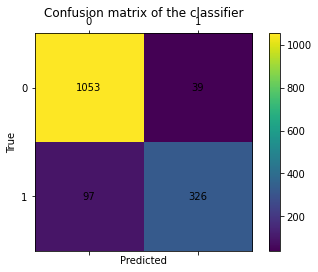

In [ ]:
# Gerando Matriz de Confusão
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm

labels = [0,1]
#tlabels = list(target_test.map({0:'Não_Saúde', 1:'Saúde'}))
cm = confusion_matrix(y, p, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
for x in range(len(cm)):
    for z in range(len(cm)):
        plt.annotate(str(cm[x][z]), xy=(z, x),
                    horizontalalignment='center',
                    verticalalignment='center')
plt.cm.Blues
plt.show()